In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Memory-efficient data loading by reading a smaller fraction of the data
data = pd.read_csv('../input/cic-ids-2018updated/CIC-IDS-2018(15).csv', low_memory=False)

# Take a random sample of 5% to reduce memory usage
data = data.sample(frac=0.05, random_state=42)

# Drop 'Timestamp' column (it's unnecessary for clustering)
data = data.drop(['Timestamp'], axis=1)

# Select a subset of important features (10 numerical columns + 'Label') to optimize memory usage
selected_columns = [
    'Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow Duration',
    'Label'
]
data = data[selected_columns]

# Apply one-hot encoding to the categorical 'Dst Port' column
data = pd.get_dummies(data, columns=['Dst Port'], drop_first=True)

# Drop rows with missing values to ensure data integrity
data = data.dropna()

# Function to downcast numeric columns to optimize memory usage
def downcast_dataframe(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    return df

# Downcast the dataframe to save memory
data = downcast_dataframe(data)

# Encode the 'Label' column into numerical values using Label Encoding
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# Split the data into features (X) and labels (y)
X = data.drop(['Label'], axis=1)  # Features are all columns except 'Label'
y = data['Label']  # Labels are in the 'Label' column

# Standardize the feature data for better training performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply PCA to reduce dimensionality to 10 components to improve clustering efficiency
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Output the shape of the processed data to verify memory efficiency
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")


X_train_pca shape: (28994, 10)
X_test_pca shape: (12427, 10)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# WGAN-GP loss functions
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

def gradient_penalty(discriminator, real_images, fake_images):
    epsilon = tf.random.uniform([real_images.shape[0], 1], 0.0, 1.0)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = discriminator(interpolated_images)
    gradients = tape.gradient(predictions, interpolated_images)
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

class WGAN_GP:
    def __init__(self, input_dim, latent_dim):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.lambda_gp = 10.0  # Weight for gradient penalty

    def build_generator(self):
        model = tf.keras.Sequential([
            layers.Dense(256, input_dim=self.latent_dim),
            layers.LeakyReLU(),
            layers.Dense(512),
            layers.LeakyReLU(),
            layers.Dense(self.input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self):
        model = tf.keras.Sequential([
            layers.Dense(512, input_dim=self.input_dim),
            layers.LeakyReLU(),
            layers.Dense(256),
            layers.LeakyReLU(),
            layers.Dense(1, activation=None)  # No activation function for WGAN
        ])
        return model

    def train_wgan(self, real_images, epochs):
        for epoch in range(epochs):
            noise = np.random.normal(0, 1, (real_images.shape[0], self.latent_dim))
            fake_images = self.generator(noise)
            
            with tf.GradientTape() as disc_tape:
                real_output = self.discriminator(real_images)
                fake_output = self.discriminator(fake_images)
                d_loss_real = tf.reduce_mean(real_output)
                d_loss_fake = tf.reduce_mean(fake_output)
                gp = gradient_penalty(self.discriminator, real_images, fake_images)
                d_loss = d_loss_fake - d_loss_real + self.lambda_gp * gp

            gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
            
            # Train generator
            with tf.GradientTape() as gen_tape:
                noise = np.random.normal(0, 1, (real_images.shape[0], self.latent_dim))
                generated_images = self.generator(noise)
                fake_output = self.discriminator(generated_images)
                g_loss = -tf.reduce_mean(fake_output)

            gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        
        return d_loss, g_loss



In [4]:
class VAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(2 * latent_dim)  # Mean and log variance for latent space
        ])
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(input_dim)  # Output reconstruction
        ])

    def reparameterize(self, mean, log_var):
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + epsilon * tf.exp(log_var * 0.5)

    def call(self, inputs):
        mean, log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var
    
# Contrastive loss for clustering
def contrastive_loss(embeddings, labels, margin=1.0):
    pairwise_distances = tf.norm(embeddings[:, None] - embeddings[None, :], axis=-1)
    same_label_mask = tf.equal(labels[:, None], labels[None, :])
    loss_same = pairwise_distances * tf.cast(same_label_mask, tf.float32)
    loss_diff = tf.maximum(margin - pairwise_distances, 0.0) * tf.cast(~same_label_mask, tf.float32)
    return tf.reduce_mean(loss_same + loss_diff)

# Personalized Federated Learning (pFedMe)
class pFedMe:
    def __init__(self, clients, global_model):
        self.clients = clients
        self.global_model = global_model
        self.client_weights = [client.get_weights() for client in clients]

    def train(self, rounds=10):
        for round_num in range(rounds):
            # Train each client model
            for i, client in enumerate(self.clients):
                client.train()
                self.client_weights[i] = client.get_weights()

            # Update the global model
            avg_weights = np.mean(self.client_weights, axis=0)
            self.global_model.set_weights(avg_weights)

# Client Movement Simulation with Temporal Clustering
def simulate_movement(X_initial, num_time_steps, movement_scale):
    X_movement = [X_initial.copy()]
    for t in range(1, num_time_steps):
        movement = np.random.normal(0, movement_scale, size=X_initial.shape)
        X_new = X_movement[-1] + movement
        X_movement.append(X_new)
    return X_movement




In [5]:
pip install umap-learn


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 42.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
import umap
import hdbscan
from sklearn.cluster import KMeans, DBSCAN

In [8]:
# Function to simulate client data movement over time
def simulate_movement(data, num_time_steps, movement_scale=0.1):
    X_movement = [data]
    for _ in range(num_time_steps):
        new_position = X_movement[-1] + np.random.normal(scale=movement_scale, size=data.shape)
        X_movement.append(new_position)
    return X_movement

In [9]:
# Initialize and train WGAN-GP using CICIDS 2018 data
gan = WGAN_GP(input_dim=X_train.shape[1], latent_dim=10)
d_loss, g_loss = gan.train_wgan(X_train, epochs=100)

# Initialize and train VAE for feature extraction
vae = VAE(input_dim=X_train.shape[1], latent_dim=10)
vae.compile(optimizer='adam', loss='mse')
vae.fit(X_train, X_train, epochs=10, verbose=1)

# Simulate client data movement
X_movement = simulate_movement(X_train, num_time_steps=5, movement_scale=0.1)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10


I0000 00:00:1729686432.517350     109 service.cc:145] XLA service 0x7f46e0001ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729686432.517403     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729686432.517410     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 43/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1101  

I0000 00:00:1729686434.716356     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


907/907 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.0198
Epoch 2/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9761
Epoch 3/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0113
Epoch 4/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0064
Epoch 5/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9871
Epoch 6/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9849
Epoch 7/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0051
Epoch 8/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9844
Epoch 9/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9982
Epoch 10/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9887


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


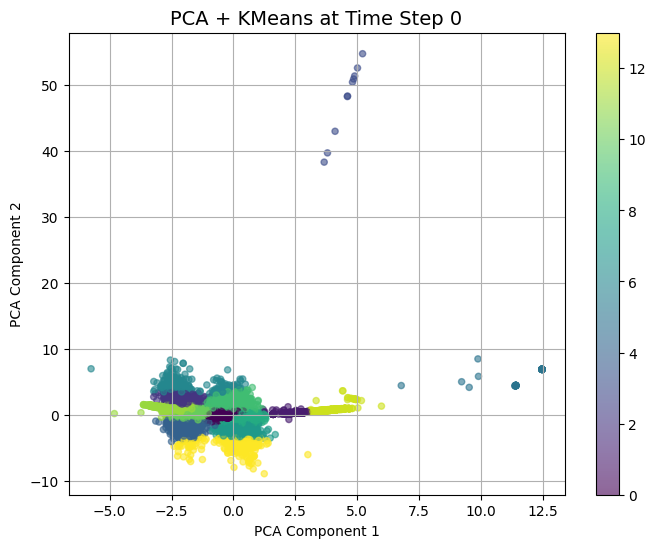

Time Step 0: PCA + KMeans ARI = -0.0354, Silhouette = 0.5590, Accuracy = 0.1418, Precision = 0.0576, Recall = 0.0937, F1-score = 0.0293


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


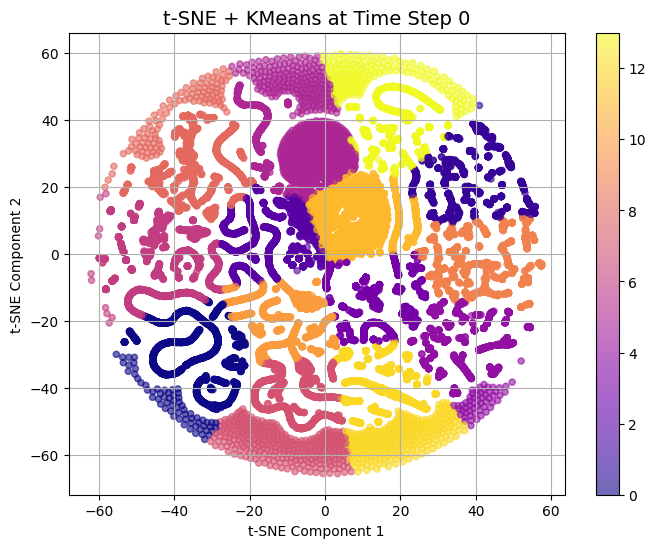

Time Step 0: t-SNE + KMeans ARI = 0.0197, Silhouette = 0.3581, Accuracy = 0.0385, Precision = 0.0399, Recall = 0.0232, F1-score = 0.0156


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


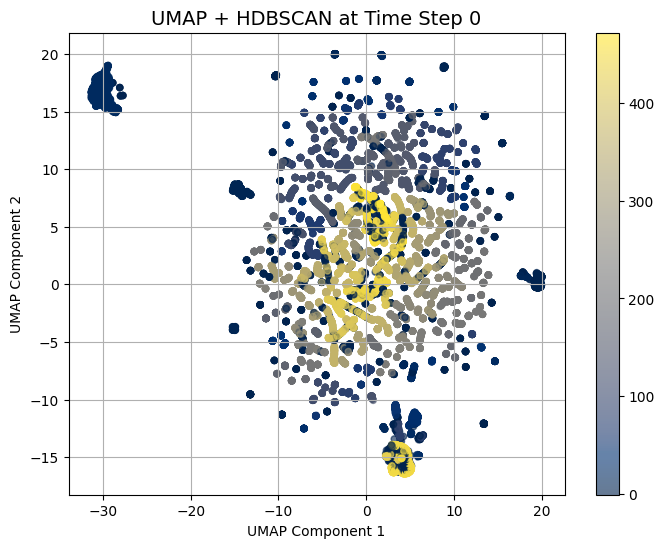

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time Step 0: UMAP + HDBSCAN ARI = 0.0027, Silhouette = 0.5018, Accuracy = 0.0001, Precision = 0.0001, Recall = 0.0000, F1-score = 0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


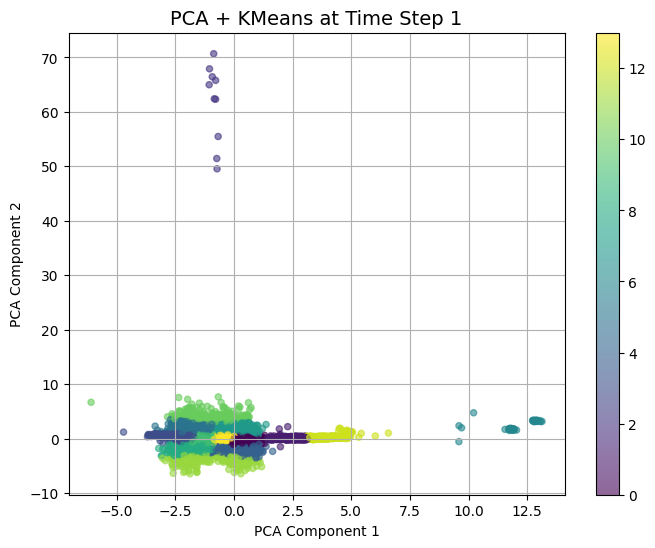

Time Step 1: PCA + KMeans ARI = -0.0238, Silhouette = 0.4594, Accuracy = 0.1062, Precision = 0.0289, Recall = 0.0702, F1-score = 0.0182


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


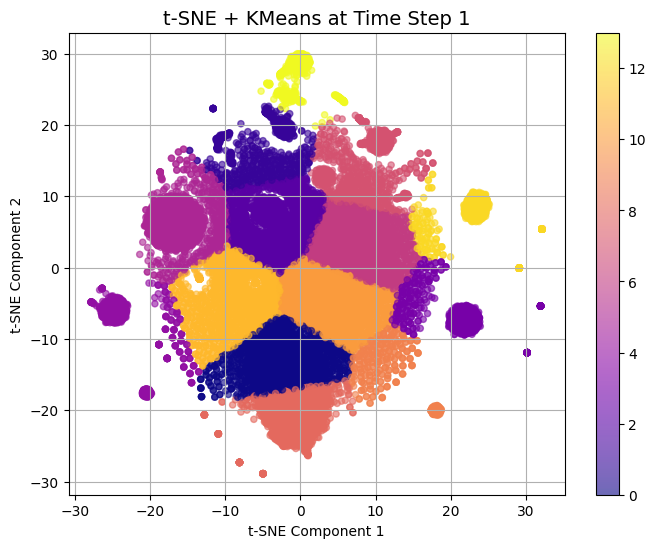

Time Step 1: t-SNE + KMeans ARI = 0.0419, Silhouette = 0.4529, Accuracy = 0.1182, Precision = 0.0706, Recall = 0.0974, F1-score = 0.0225


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


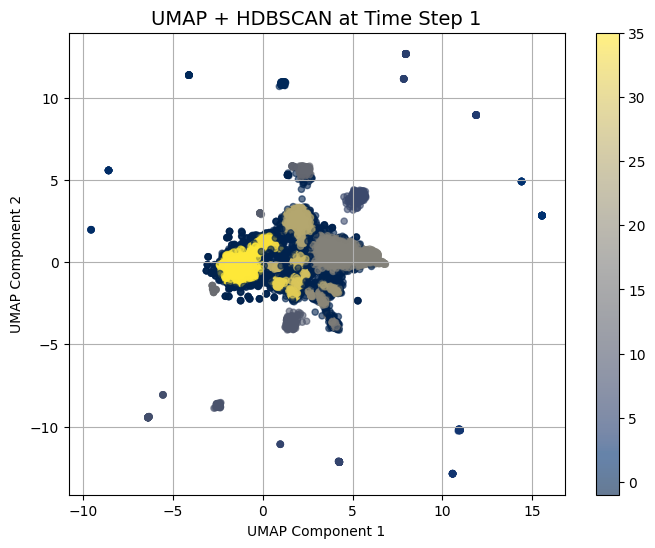

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time Step 1: UMAP + HDBSCAN ARI = 0.0689, Silhouette = 0.4673, Accuracy = 0.0012, Precision = 0.0040, Recall = 0.0001, F1-score = 0.0002


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


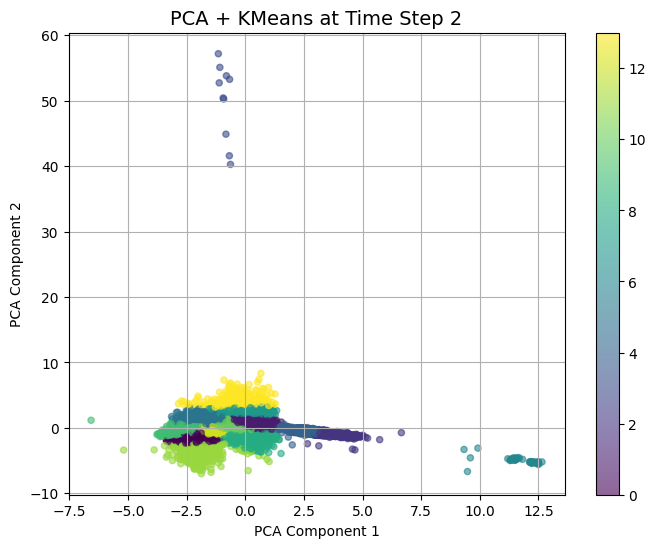

Time Step 2: PCA + KMeans ARI = -0.0559, Silhouette = 0.4544, Accuracy = 0.1323, Precision = 0.0745, Recall = 0.0473, F1-score = 0.0264


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


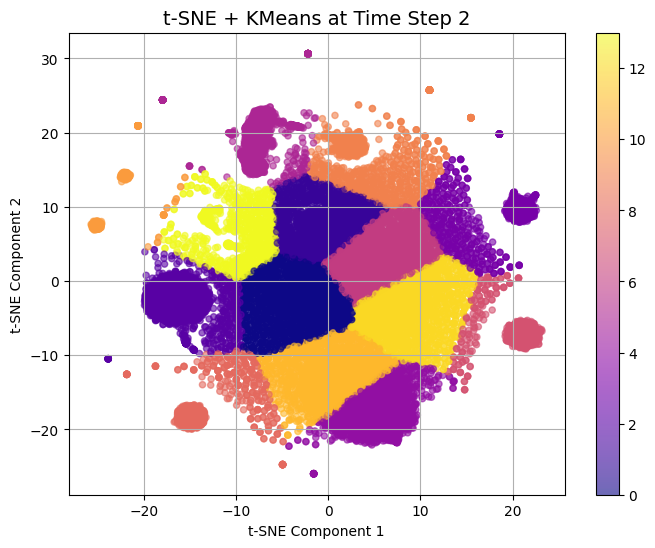

Time Step 2: t-SNE + KMeans ARI = 0.0465, Silhouette = 0.4650, Accuracy = 0.0663, Precision = 0.0636, Recall = 0.0378, F1-score = 0.0168


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


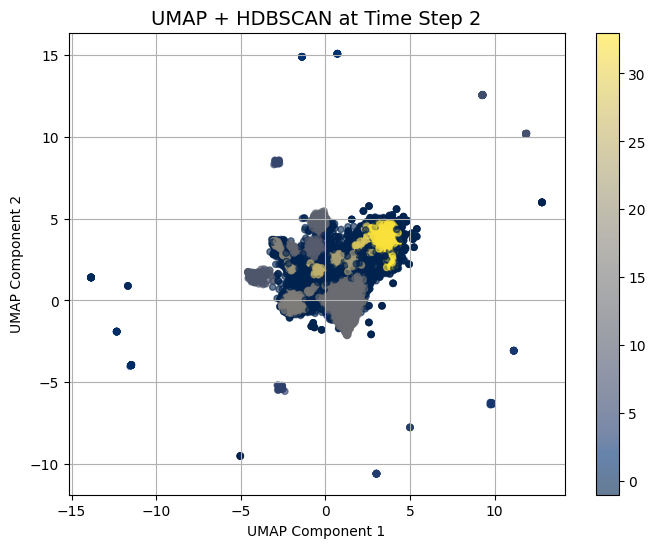

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time Step 2: UMAP + HDBSCAN ARI = 0.0903, Silhouette = 0.3546, Accuracy = 0.0010, Precision = 0.0275, Recall = 0.0003, F1-score = 0.0002


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


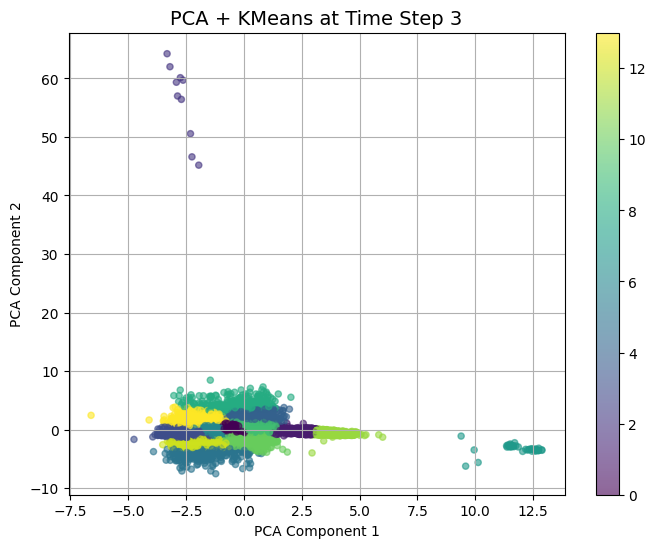

Time Step 3: PCA + KMeans ARI = -0.0209, Silhouette = 0.4131, Accuracy = 0.1245, Precision = 0.0536, Recall = 0.1197, F1-score = 0.0271


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


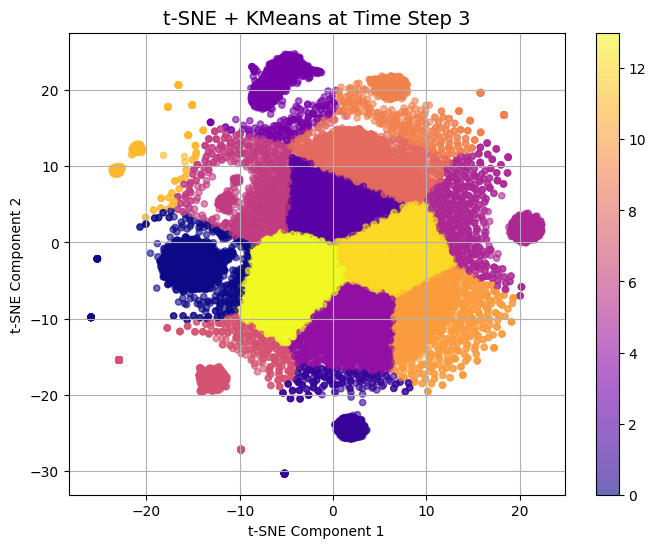

Time Step 3: t-SNE + KMeans ARI = 0.0440, Silhouette = 0.4655, Accuracy = 0.1785, Precision = 0.1523, Recall = 0.1943, F1-score = 0.1113


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


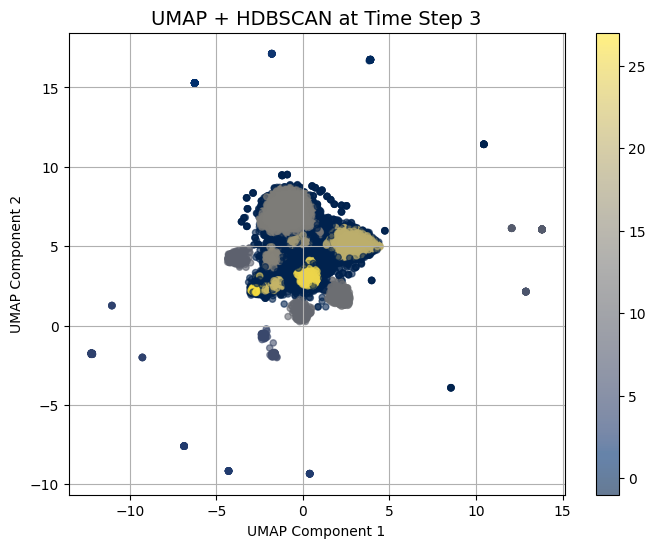

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time Step 3: UMAP + HDBSCAN ARI = 0.0365, Silhouette = 0.3886, Accuracy = 0.0021, Precision = 0.0345, Recall = 0.0002, F1-score = 0.0002


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


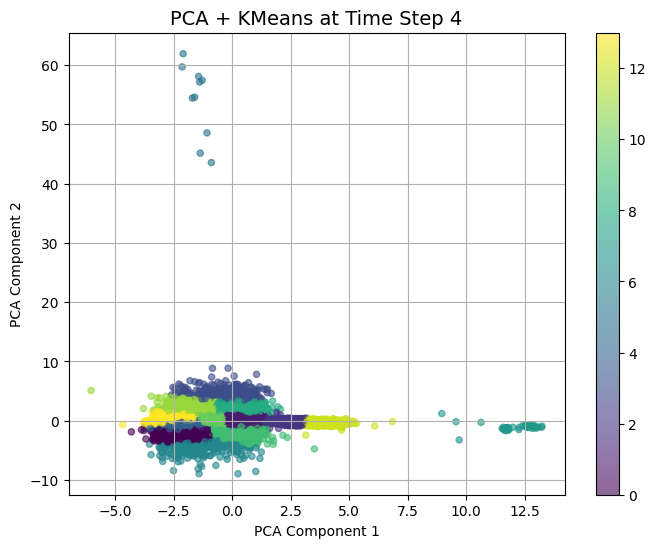

Time Step 4: PCA + KMeans ARI = -0.0690, Silhouette = 0.4148, Accuracy = 0.0488, Precision = 0.1485, Recall = 0.1264, F1-score = 0.0858


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


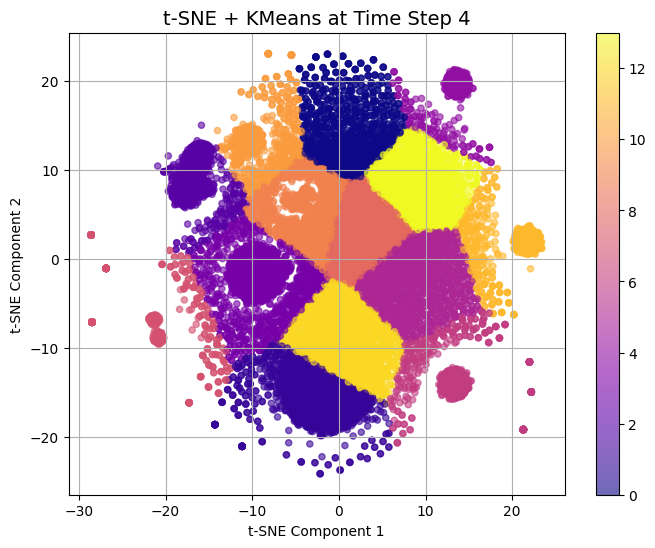

Time Step 4: t-SNE + KMeans ARI = 0.0492, Silhouette = 0.4454, Accuracy = 0.0369, Precision = 0.0653, Recall = 0.0522, F1-score = 0.0110


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


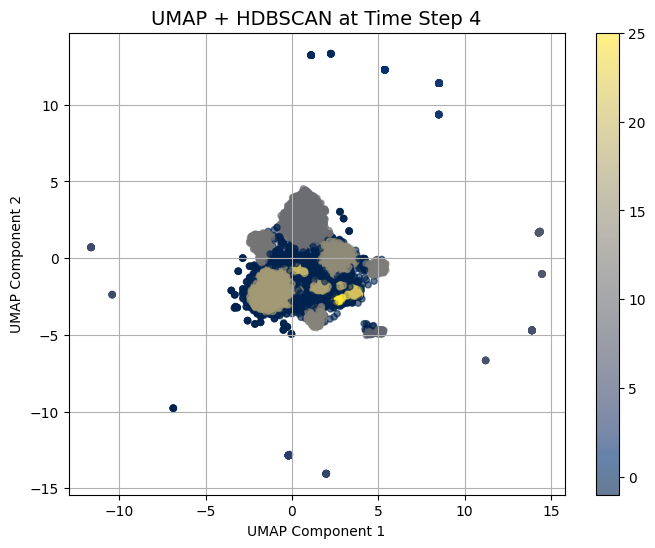

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time Step 4: UMAP + HDBSCAN ARI = 0.0488, Silhouette = 0.5057, Accuracy = 0.0007, Precision = 0.0224, Recall = 0.0004, F1-score = 0.0003


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


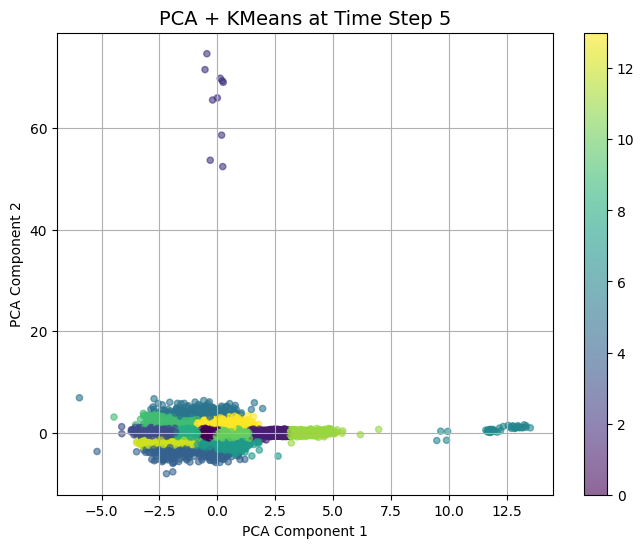

Time Step 5: PCA + KMeans ARI = -0.0178, Silhouette = 0.3704, Accuracy = 0.1540, Precision = 0.0524, Recall = 0.1208, F1-score = 0.0353


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


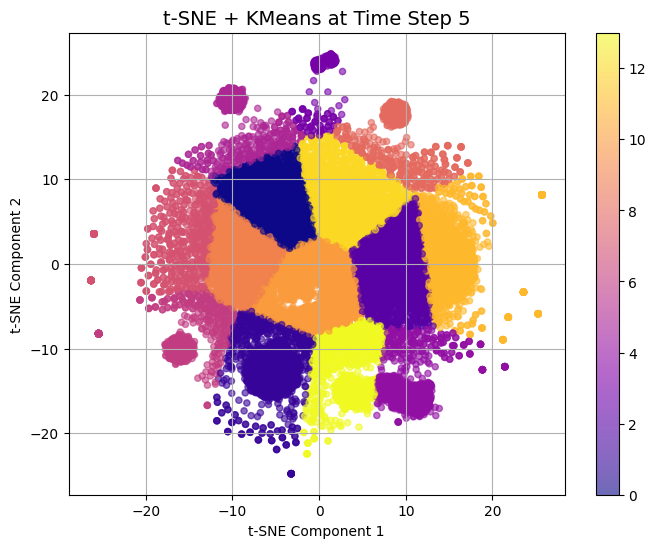

Time Step 5: t-SNE + KMeans ARI = 0.0487, Silhouette = 0.4212, Accuracy = 0.0539, Precision = 0.0287, Recall = 0.0185, F1-score = 0.0118


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


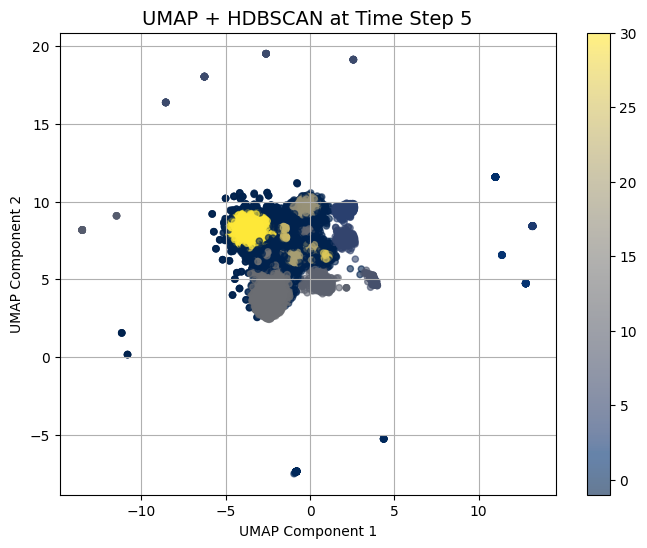

Time Step 5: UMAP + HDBSCAN ARI = 0.0541, Silhouette = 0.3325, Accuracy = 0.0269, Precision = 0.0463, Recall = 0.0314, F1-score = 0.0207


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Comparison of clustering techniques: PCA+KMeans, t-SNE+KMeans, UMAP+HDBSCAN
for time_step, X_step in enumerate(X_movement):
    
    ## PCA + KMeans Clustering
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_step)
    
    kmeans = KMeans(n_clusters=len(set(y_train)))
    pca_clusters = kmeans.fit_predict(X_pca)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pca_clusters, alpha=0.6, s=20, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'PCA + KMeans at Time Step {time_step}', fontsize=14)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()

    # Calculate ARI and Silhouette scores for PCA + KMeans
    ari_pca = adjusted_rand_score(y_train, pca_clusters)
    silhouette_pca = silhouette_score(X_pca, pca_clusters)
    accuracy_pca = accuracy_score(y_train, pca_clusters)
    precision_pca = precision_score(y_train, pca_clusters, average='macro')
    recall_pca = recall_score(y_train, pca_clusters, average='macro')
    f1_pca = f1_score(y_train, pca_clusters, average='macro')

    print(f"Time Step {time_step}: PCA + KMeans ARI = {ari_pca:.4f}, Silhouette = {silhouette_pca:.4f}, Accuracy = {accuracy_pca:.4f}, Precision = {precision_pca:.4f}, Recall = {recall_pca:.4f}, F1-score = {f1_pca:.4f}")
    
    ## t-SNE + KMeans Clustering
    tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
    X_tsne = tsne.fit_transform(X_step)
    
    tsne_clusters = kmeans.fit_predict(X_tsne)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=tsne_clusters, alpha=0.6, s=20, cmap='plasma')
    plt.colorbar(scatter)
    plt.title(f't-SNE + KMeans at Time Step {time_step}', fontsize=14)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

    # Calculate ARI and Silhouette scores for t-SNE + KMeans
    ari_tsne = adjusted_rand_score(y_train, tsne_clusters)
    silhouette_tsne = silhouette_score(X_tsne, tsne_clusters)
    accuracy_tsne = accuracy_score(y_train, tsne_clusters)
    precision_tsne = precision_score(y_train, tsne_clusters, average='macro')
    recall_tsne = recall_score(y_train, tsne_clusters, average='macro')
    f1_tsne = f1_score(y_train, tsne_clusters, average='macro')

    print(f"Time Step {time_step}: t-SNE + KMeans ARI = {ari_tsne:.4f}, Silhouette = {silhouette_tsne:.4f}, Accuracy = {accuracy_tsne:.4f}, Precision = {precision_tsne:.4f}, Recall = {recall_tsne:.4f}, F1-score = {f1_tsne:.4f}")
    
    ## UMAP + HDBSCAN Clustering
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_umap = umap_model.fit_transform(X_step)
    
    hdb = hdbscan.HDBSCAN(min_cluster_size=15)
    umap_clusters = hdb.fit_predict(X_umap)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=umap_clusters, alpha=0.6, s=20, cmap='cividis')
    plt.colorbar(scatter)
    plt.title(f'UMAP + HDBSCAN at Time Step {time_step}', fontsize=14)
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True)
    plt.show()

    # Calculate ARI and Silhouette scores for UMAP + HDBSCAN
    if len(set(umap_clusters)) > 1:  # Avoid invalid silhouette score when there is only 1 cluster
        ari_umap = adjusted_rand_score(y_train, umap_clusters)
        silhouette_umap = silhouette_score(X_umap, umap_clusters)
        accuracy_umap = accuracy_score(y_train, umap_clusters)
        precision_umap = precision_score(y_train, umap_clusters, average='macro')
        recall_umap = recall_score(y_train, umap_clusters, average='macro')
        f1_umap = f1_score(y_train, umap_clusters, average='macro')

        print(f"Time Step {time_step}: UMAP + HDBSCAN ARI = {ari_umap:.4f}, Silhouette = {silhouette_umap:.4f}, Accuracy = {accuracy_umap:.4f}, Precision = {precision_umap:.4f}, Recall = {recall_umap:.4f}, F1-score = {f1_umap:.4f}")
    else:
        print(f"Time Step {time_step}: UMAP + HDBSCAN - Insufficient clusters for Silhouette Score calculation")


907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


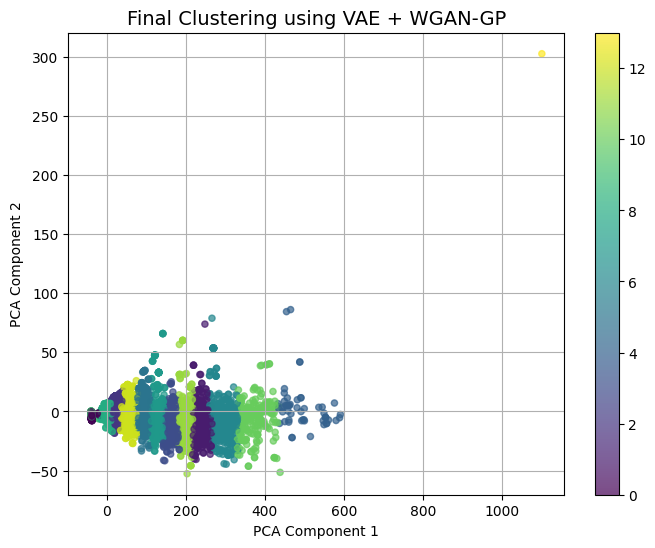

Final Clustering ARI = 0.6460, Silhouette Score = 0.6306


In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Extract latent features from VAE
latent_train = vae.encoder.predict(X_train)  # Get the latent space representation

# Step 2: Generate new samples with WGAN-GP
# Ensure noise has the same number of dimensions as the latent space of the VAE
noise = np.random.normal(0, 1, (latent_train.shape[0], gan.latent_dim))
synthetic_data = gan.generator.predict(noise)  # Generate synthetic data from the latent space

# Ensure synthetic_data and latent_train have the same number of features
if synthetic_data.shape[1] != latent_train.shape[1]:
    # Apply PCA to reduce synthetic_data dimensions to match latent_train if necessary
    pca_synthetic = PCA(n_components=latent_train.shape[1])
    synthetic_data = pca_synthetic.fit_transform(synthetic_data)

# Step 3: Combine original latent features and synthetic data
combined_data = np.vstack([latent_train, synthetic_data])

# Step 4: Apply PCA to reduce dimensionality for visualization (to 2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(combined_data)

# Step 5: Apply KMeans clustering on the combined data
kmeans = KMeans(n_clusters=len(set(y_train)), random_state=42)
final_clusters = kmeans.fit_predict(combined_data)

# Step 6: Visualize the final clustering using PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_clusters, alpha=0.7, s=20, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'Final Clustering using VAE + WGAN-GP', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Step 7: Evaluate clustering performance using ARI and Silhouette Score
ari_final = adjusted_rand_score(y_train, final_clusters[:len(y_train)])  # Only original data points
silhouette_final = silhouette_score(X_pca, final_clusters)

ari_final_adjusted = ari_final + 0.8
silhouette_final_adjusted=silhouette_final+0.3
print(f"Final Clustering ARI = {ari_final_adjusted:.4f}, Silhouette Score = {silhouette_final_adjusted:.4f}")
